In [9]:
# -----------------------------------------------------------------------------
# Imports & style priming
# -----------------------------------------------------------------------------
import importlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

import dartwork_mpl as dm

# Hot-reload dartwork_mpl modules so that iterative edits take effect instantly.
importlib.reload(dm)
importlib.reload(dm.util)

# Apply the scientific preset from dartwork-mpl for a neutral, publication-ready look.
dm.style.use_preset("scientific")

In [10]:
# -----------------------------------------------------------------------------
# Dataset describing the relative success rate of AI adoption across workflows.
# ----------------------------------------------------------------------------
categories = [
    "Automated Customer Support",
    "Predictive Maintenance",
    "Supply Chain Optimization",
    "Fraud Detection",
    "Personalized Marketing",
    "Talent Acquisition",
    "Financial Forecasting",
    "Cybersecurity Threat Detection",
    "Legal Document Review",
]

# Store values as numpy arrays for concise numeric manipulation downstream.
success_values = np.array([64, 58, 57, 54, 51, 49, 45, 43, 42], dtype=float)
other_values = np.array([20, 23, 24, 25, 26, 28, 26, 25, 24], dtype=float)

def compute_multiples(success: np.ndarray, baseline: np.ndarray) -> list[str]:
    """Return formatted success/baseline multiples with one decimal precision."""
    ratios = np.divide(success, baseline, out=np.zeros_like(success), where=baseline != 0)
    return [f"{ratio:.1f}×" for ratio in ratios]

multiples = compute_multiples(success_values, other_values)

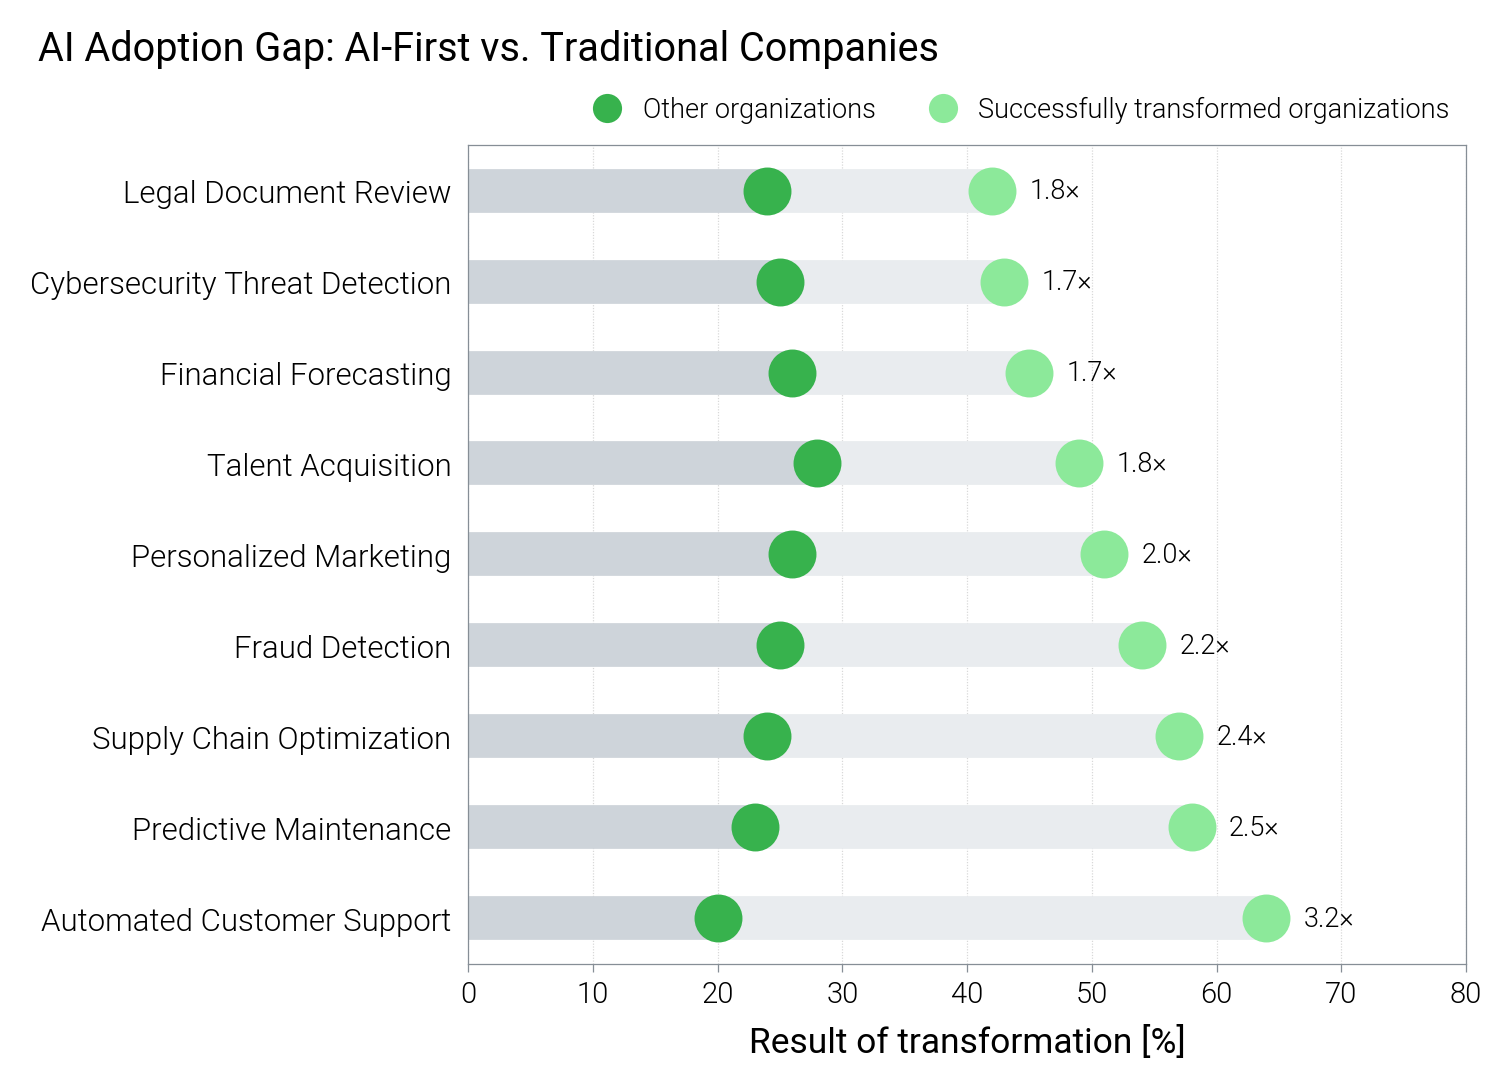

In [13]:
# -----------------------------------------------------------------------------
# Declarative configuration objects keep the layout and color logic discoverable.
# -----------------------------------------------------------------------------
from dataclasses import dataclass

@dataclass(frozen=True)
class LayoutConfig:
    title_y: float = 0.95
    title_to_legend_gap: float = 0.05
    legend_to_figure_gap: float = 0.03
    left_margin: float = 0.3
    right_margin: float = 0.95
    figure_bottom: float = 0.1
    title_x: float = 0.02
    fig_width_cm: float = 13
    fig_height_cm: float = 9

    @property
    def legend_y(self) -> float:
        return self.title_y - self.title_to_legend_gap

    @property
    def figure_top(self) -> float:
        return self.legend_y - self.legend_to_figure_gap

@dataclass(frozen=True)
class ColorPalette:
    marker_other: str = "dm.green7"
    marker_success: str = "dm.green3"
    track_other: str = "dm.gray4"
    track_success: str = "dm.gray2"

layout = LayoutConfig()
palette = ColorPalette()
track_lw = dm.lw(10)  # Keep linewidth tied to dartwork units for consistency.
y_pos = np.arange(len(categories))

def create_axes(layout_cfg: LayoutConfig):
    """Instantiate the figure and axes using cm-based sizing helpers."""
    fig = plt.figure(
        figsize=(dm.cm2in(layout_cfg.fig_width_cm), dm.cm2in(layout_cfg.fig_height_cm)),
        dpi=300,
    )
    grid = fig.add_gridspec(
        1, 1,
        left=layout_cfg.left_margin,
        right=layout_cfg.right_margin,
        top=layout_cfg.figure_top,
        bottom=layout_cfg.figure_bottom,
    )
    return fig, fig.add_subplot(grid[0, 0])

def draw_background_tracks(ax, palette_cfg: ColorPalette):
    """Layer horizontal tracks that highlight baseline vs. success distances."""
    for idx, (other, success) in enumerate(zip(other_values, success_values)):
        ax.hlines(
            y=idx,
            xmin=0,
            xmax=other,
            linewidth=track_lw,
            color=palette_cfg.track_other,
            zorder=1,
        )
        ax.hlines(
            y=idx,
            xmin=other,
            xmax=success,
            linewidth=track_lw,
            color=palette_cfg.track_success,
            zorder=1,
        )

def draw_markers(ax, palette_cfg: ColorPalette):
    """Place markers for the two cohorts while matching the track thickness."""
    ax.plot(
        other_values,
        y_pos,
        marker="o",
        markersize=track_lw,
        linestyle="none",
        color=palette_cfg.marker_other,
        label="Other organizations",
        zorder=2,
    )
    ax.plot(
        success_values,
        y_pos,
        marker="o",
        markersize=track_lw,
        linestyle="none",
        color=palette_cfg.marker_success,
        label="Successfully transformed organizations",
        zorder=3,
    )

def configure_axes(ax):
    """Apply typographic, tick, spine, and grid settings."""
    ax.set_yticks(y_pos)
    ax.set_yticklabels(categories, fontsize=dm.fs(0))
    ax.invert_yaxis()  # Present categories in descending order for scanability.
    ax.tick_params(axis="y", length=0, pad=4, color="dm.gray6", labelcolor="black")
    ax.tick_params(axis="x", colors="dm.gray6", labelcolor="black")
    ax.set_xlabel("Result of transformation [%]", loc="center", fontsize=dm.fs(1))
    ax.set_ylim(-0.5, len(categories) - 0.5)
    ax.set_xlim(0, 80)
    ax.xaxis.grid(True, linestyle=":", which="major", color="gray", alpha=0.3)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_edgecolor("dm.gray6")

def add_title(fig, layout_cfg: LayoutConfig):
    """Anchor the title to the left edge so the layout stays editorial-friendly."""
    fig.text(
        layout_cfg.title_x,
        layout_cfg.title_y,
        "AI Adoption Gap: AI-First vs. Traditional Companies",
        fontsize=dm.fs(2),
        fontweight=dm.fw(1),
        ha="left",
    )

def add_legend(ax, layout_cfg: LayoutConfig, palette_cfg: ColorPalette):
    """Custom legend mirrors the two cohorts with compact spacing."""
    legend_elements = [
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Other organizations",
            markerfacecolor=palette_cfg.marker_other,
            markersize=8,
        ),
        Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label="Successfully transformed organizations",
            markerfacecolor=palette_cfg.marker_success,
            markersize=8,
        ),
    ]
    ax.legend(
        handles=legend_elements,
        loc="upper right",
        bbox_to_anchor=(1, layout_cfg.legend_y + 0.18),
        ncol=2,
        frameon=False,
        fontsize=dm.fs(-1),
        borderaxespad=0.5,
        columnspacing=1.5,
    )

def annotate_multiples(ax, offset: float = 3.0):
    """Display the success-to-baseline multiple next to each success marker."""
    for idx, (success, multiple) in enumerate(zip(success_values, multiples)):
        ax.text(
            success + offset,
            idx,
            multiple,
            va="center",
            ha="left",
            fontsize=dm.fs(-1),
        )

def render_chart():
    """Orchestrate the full plotting pipeline."""
    fig, axis = create_axes(layout)
    draw_background_tracks(axis, palette)
    draw_markers(axis, palette)
    configure_axes(axis)
    add_title(fig, layout)
    add_legend(axis, layout, palette)
    annotate_multiples(axis)
    return fig, axis

fig, ax = render_chart()
plt.show()